In [8]:
from IPython import display
from importlib_resources import files
from proj_xor.__main__ import main

In [2]:
main()

2023-02-11 20:29:59.477333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 20:29:59.493184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 20:29:59.493320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 20:29:59.494102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

  0%|          | 0/60 [00:00<?, ?it/s]

2023-02-11 20:30:00.683175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-11 20:30:00.684701: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f6e292e1670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-11 20:30:00.684713: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-02-11 20:30:00.688860: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-11 20:30:00.732351: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-11 20:30:00.761043: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is log

Epoch   0	Train Loss: 0.71332598	Train Accuracy: 53.39999771	Test Loss: 0.58905429	Test Accuracy: 68.00000000
Epoch   5	Train Loss: 0.35534328	Train Accuracy: 96.10000610	Test Loss: 0.27291667	Test Accuracy: 94.50000000
Epoch  10	Train Loss: 0.16648389	Train Accuracy: 92.44999695	Test Loss: 0.08799174	Test Accuracy: 99.50000000
Epoch  15	Train Loss: 0.04273916	Train Accuracy: 99.75000000	Test Loss: 0.03669458	Test Accuracy: 100.00000000
Epoch  20	Train Loss: 0.01847537	Train Accuracy: 99.90000153	Test Loss: 0.01649288	Test Accuracy: 100.00000000
Epoch  25	Train Loss: 0.00923504	Train Accuracy: 99.94999695	Test Loss: 0.00844376	Test Accuracy: 100.00000000
Epoch  30	Train Loss: 0.00538015	Train Accuracy: 99.94999695	Test Loss: 0.00498084	Test Accuracy: 100.00000000
Epoch  35	Train Loss: 0.00356649	Train Accuracy: 100.00000000	Test Loss: 0.00333717	Test Accuracy: 100.00000000
Epoch  40	Train Loss: 0.00261625	Train Accuracy: 100.00000000	Test Loss: 0.00247125	Test Accuracy: 100.00000000
Ep

In [3]:
display.Code(files("proj_xor").joinpath("__main__.py"))

import logging
from proj_xor.models import ProjXORWrapper
# from proj_xor.data import get_data
from proj_xor.plots import plot_data

def main(logging_level=logging.WARNING):
    logging.basicConfig(level=logging_level)
    logging.info("Entering main method.")

    M = ProjXORWrapper()

    M.fit(
        save_plots=True,
        show_plots=False,
        save_dfs=True,
        show_dfs=False,
        monitor_freq=5,
    )

    plot_data.plot_model_performance(M.get_model(), show_plt=False)

    logging.info("Exiting main method.")


if __name__ == "__main__":
    main(logging_level=logging.INFO)

In [4]:
display.Code(files("proj_xor").joinpath("models.py"))

import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Dense, Discretization
from tensorflow.keras import Model

from tensorflow.keras.losses import BinaryCrossentropy as BinaryCrossentropyLoss
from tensorflow.keras.metrics import (
    BinaryCrossentropy as BinaryCrossentropyMetric,
    BinaryAccuracy,
)
from tensorflow.keras.optimizers.experimental import Nadam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.math import argmax
from numpy import uint8
import pandas as pd
from importlib_resources import files

from tqdm.auto import trange, tqdm

from proj_xor.data import get_data
from proj_xor.plots.plot_metrics import plot_loss, plot_accuracy


class ProjXORModel(Model):
    def __init__(
        self,
        loss=None,
        optimizer=None,
        optimizer_schedule=None,
        train_loss_metric=None,
        test_loss_metric=None,
        train_acc_metric=None,
        test_acc_metric=None,
        layers=None,
    ):
        super(ProjXORModel, self).__init__()

        if layers is None:
            self._layers = [
                Dense(2, activation="swish"),
                Dense(1, activation="sigmoid"),
                # Discretization(
                #     bin_boundaries=[0.5],
                #     output_mode="int",
                #     dtype=float
                # ),
            ]
        else:
            self._layers = layers

        if loss is None:
            self.loss_object = BinaryCrossentropyLoss(from_logits=False)
        else:
            self.loss_object = loss

        if optimizer_schedule is None:
            self._optimizer_schedule = ExponentialDecay(
                2,
                decay_steps=10 ** 2,
                decay_rate=0.8,
                name="exponential_decay_schedule",
            )
        else:
            self._optimizer_schedule = optimizer_schedule
        if optimizer is None:
            self._optimizer = Nadam(
                learning_rate=self._optimizer_schedule,
                name="nadam_optimizer",
            )
        else:
            self._optimizer = optimizer

        if train_loss_metric is None:
            self.train_loss = BinaryCrossentropyMetric(name="train_loss")
        else:
            self.train_loss = train_loss_metric
        if train_acc_metric is None:
            self.train_accuracy = BinaryAccuracy(name="train_accuracy")
        else:
            self.train_accuracy = train_acc_metric

        if test_loss_metric is None:
            self.test_loss = BinaryCrossentropyMetric(name="test_loss")
        else:
            self.test_loss = test_loss_metric
        if test_acc_metric is None:
            self.test_accuracy = BinaryAccuracy(name="test_accuracy")
        else:
            self.test_accuracy = test_acc_metric

    def call(self, x):
        for f in self._layers:
            x = f(x)
        return x


class ProjXORWrapper:
    def __init__(
        self,
        loss=None,
        optimizer=None,
        optimizer_schedule=None,
        train_loss_metric=None,
        test_loss_metric=None,
        train_acc_metric=None,
        test_acc_metric=None,
        layers=None,
        epochs=60,
        batch_size=50,
    ):
        ## I know this function has a lot of repeated code, but fixing it is not a priority
        self._is_fitted = False

        self._epochs = epochs
        self._batch_size = batch_size

        if layers is None:
            self._layers = [
                Dense(2, activation="swish"),
                # swish works much better than relu or sigmoid
                Dense(1, activation="sigmoid"),
            ]
        else:
            self._layers = layers

        if loss is None:
            self.loss_object = BinaryCrossentropyLoss(from_logits=False)
        else:
            self.loss_object = loss

        if optimizer_schedule is None:
            self._optimizer_schedule = ExponentialDecay(
                0.5,
                decay

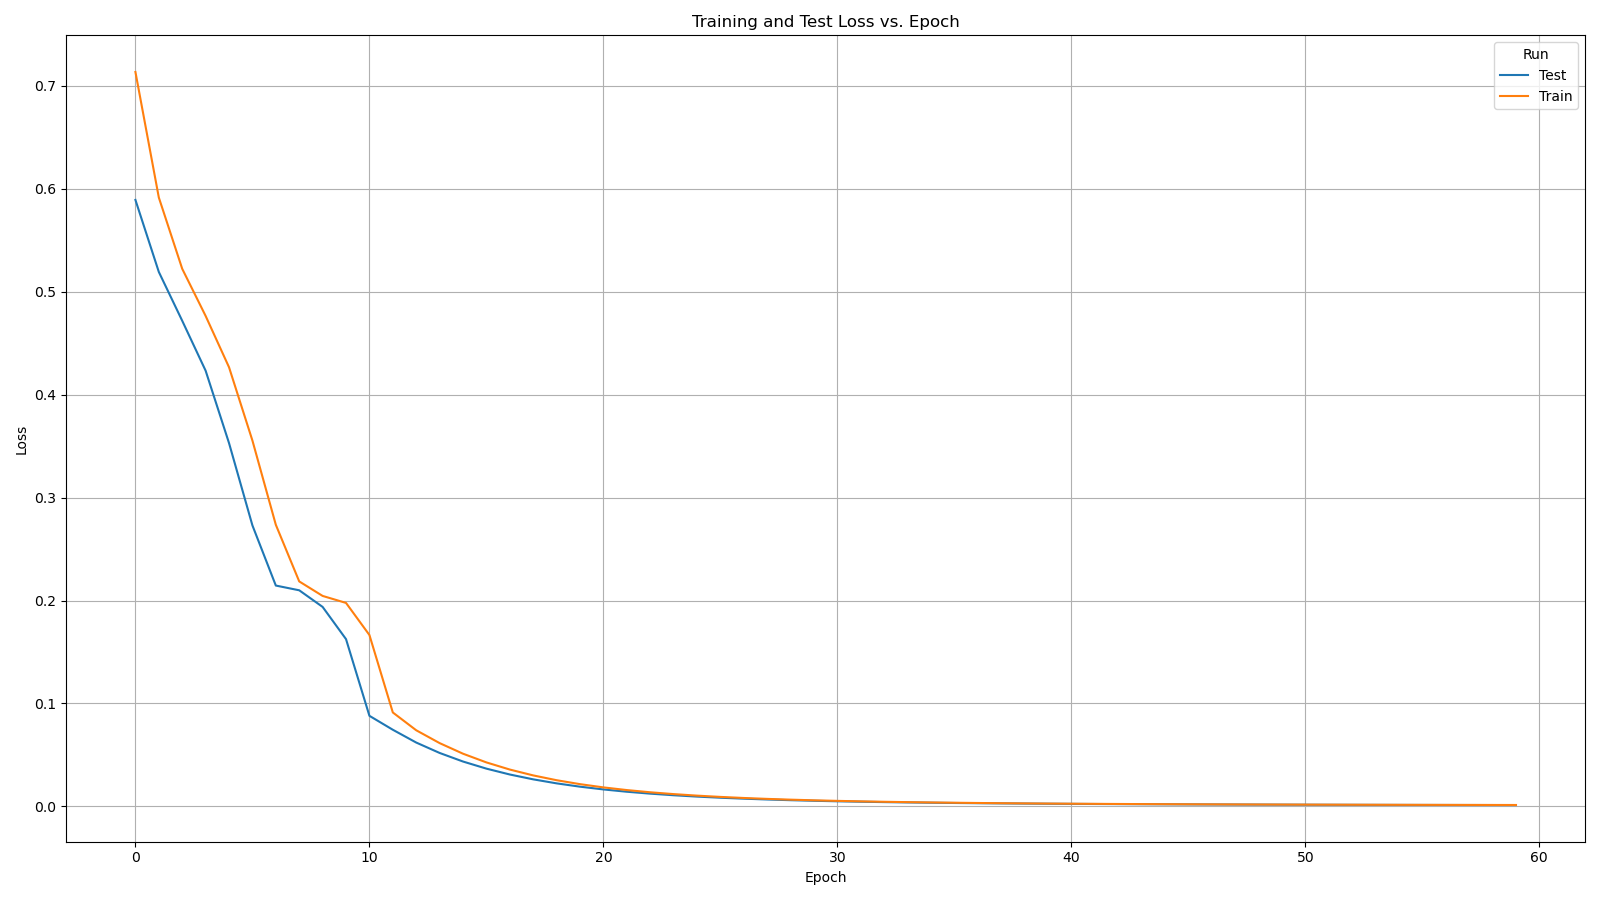

In [5]:
display.Image(files("proj_xor.plots.metrics").joinpath("loss_plot.png"))

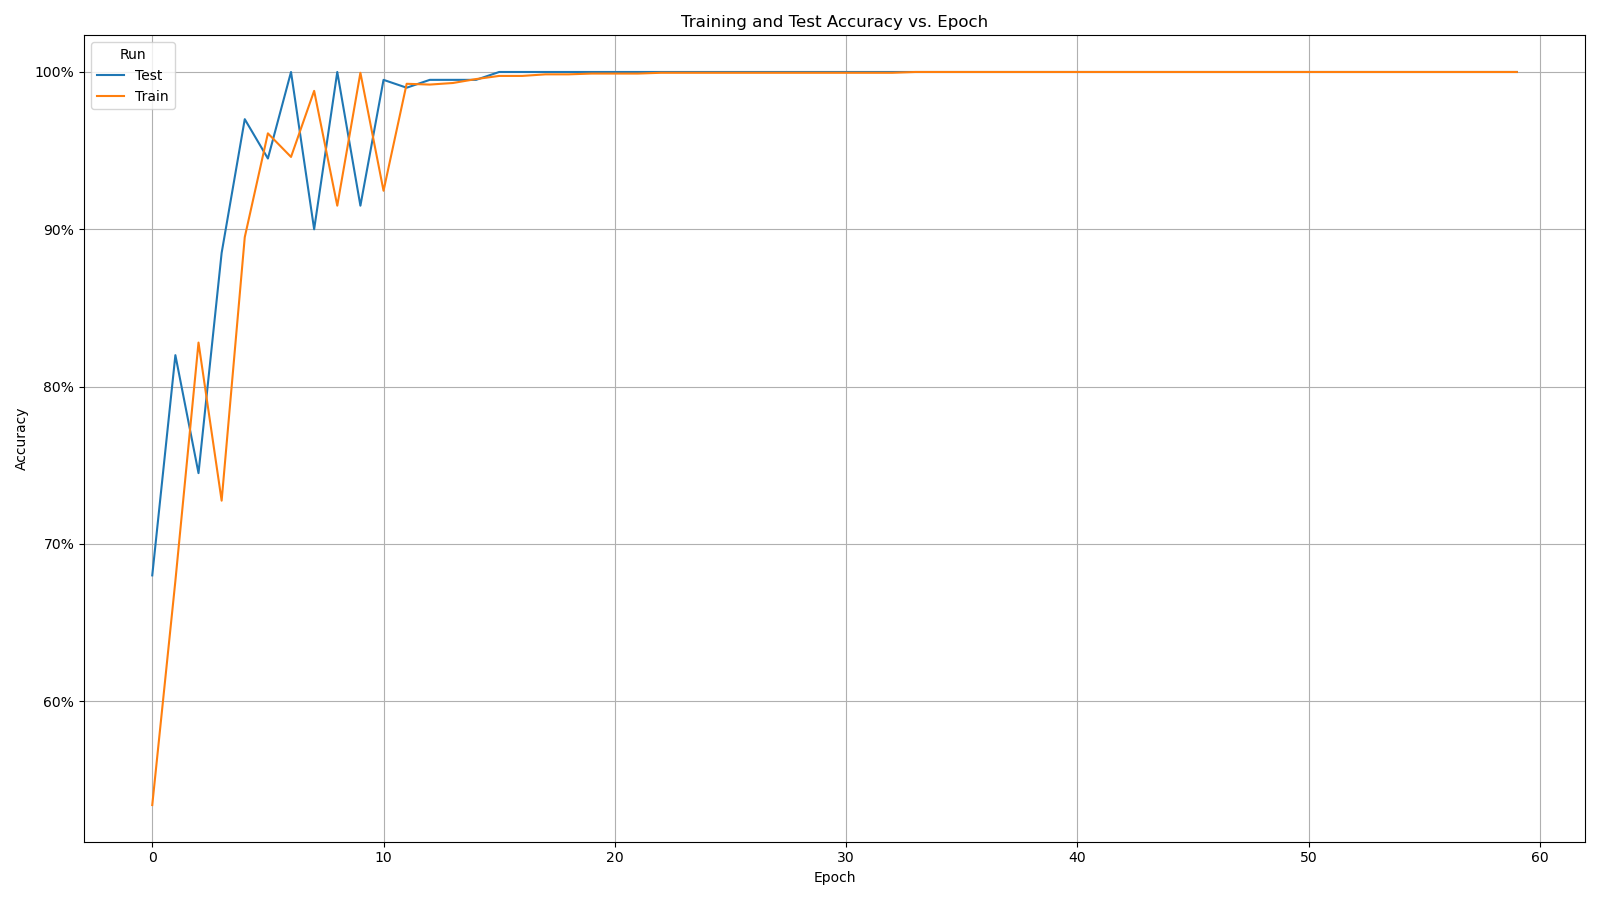

In [6]:
display.Image(files("proj_xor.plots.metrics").joinpath("accuracy_plot.png"))

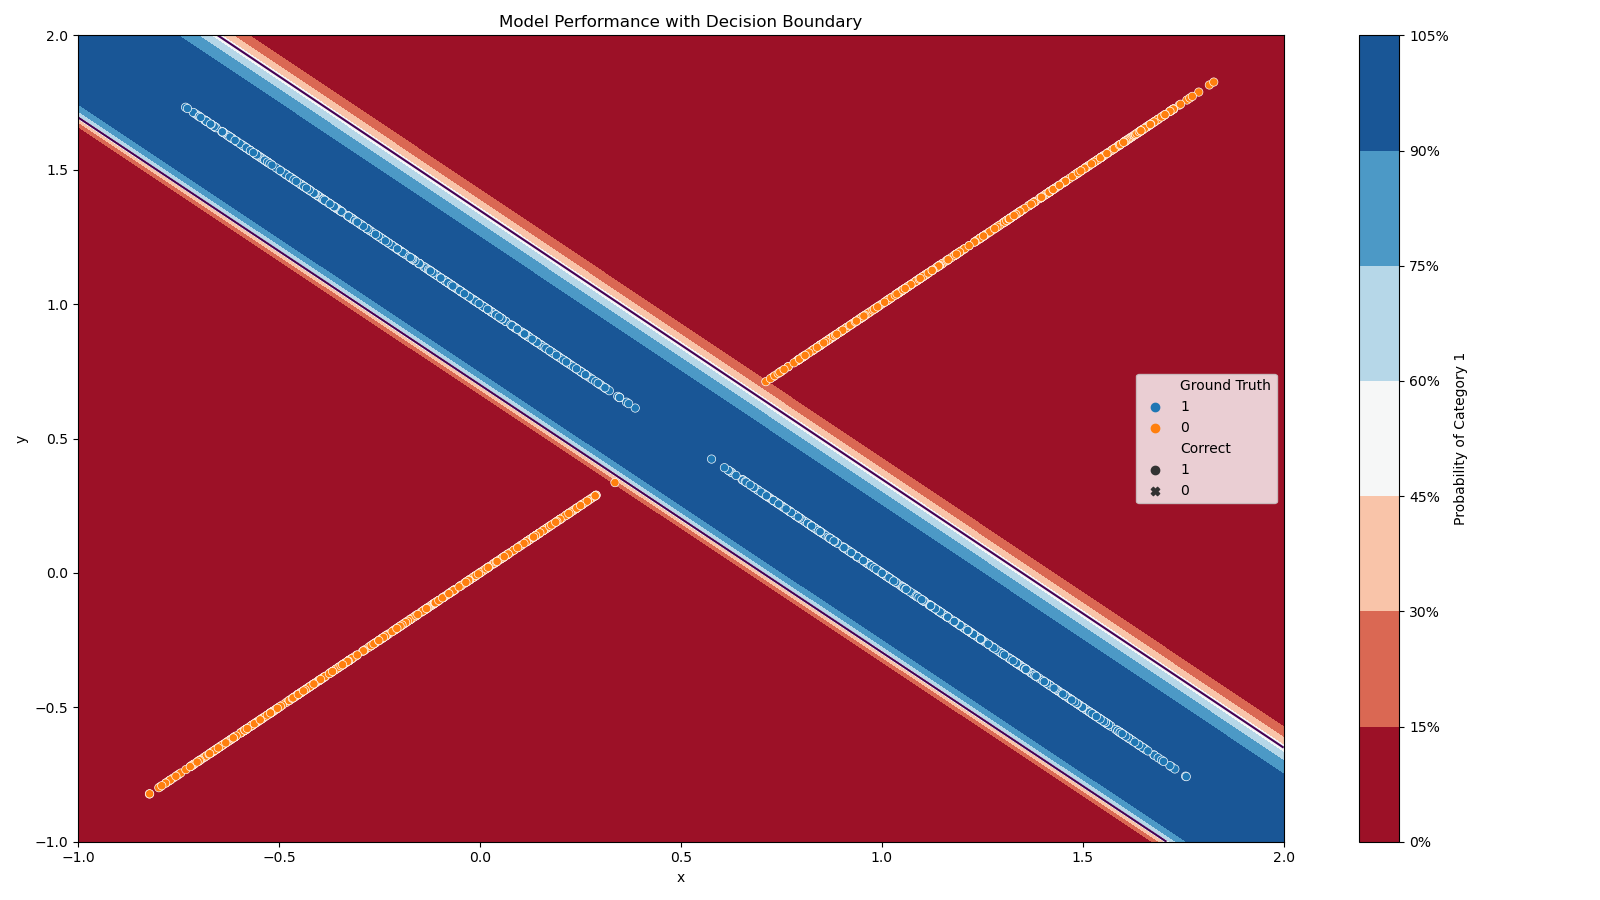

In [7]:
display.Image(files("proj_xor.plots.data").joinpath("performance.png"))